In [1]:
from utility import *

from collections import Counter
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns

%matplotlib inline

# Dataset Loading

In [4]:
combo2stitch, combo2se, se2name = load_combo_se()
net, node2idx = load_ppi()
stitch2se, se2name_mono = load_mono_se()
stitch2proteins = load_targets(fname='bio-decagon-targets-all.csv')
se2class, se2name_class = load_categories()
se2name.update(se2name_mono)
se2name.update(se2name_class)

Reading: bio-decagon-combo.csv
Drug combinations: 63473 Side effects: 1318
Drug-drug interactions: 4651131
Reading: bio-decagon-ppi.csv
Edges: 715612
Nodes: 19081
Reading: bio-decagon-mono.csv
Reading: bio-decagon-targets-all.csv
Reading: bio-decagon-effectcategories.csv


# Basic Statistics

## How many side effects does each drug combination have?

In [5]:
def plot_distribution(dist, title="", x_label="", y_label="", file_name=None):
    plt.figure(figsize=(6, 3.5))
    sns.set_context("paper", font_scale=1.8)
    sns.set_style('ticks')
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
    sns.distplot(dist, kde=False, color=sns.xkcd_rgb['red'], bins=20, hist_kws={"alpha" : 1})
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.ylabel(y_label)
    if file_name:
        plt.savefig(file_name)


Median number of side effects per drug combination 53.0


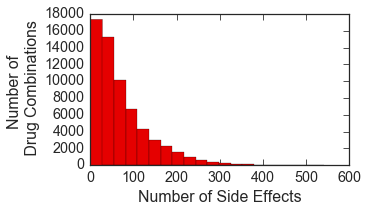

In [6]:
distribution_combos = [len(combo2se[combo]) for combo in combo2se]
print "Median number of side effects per drug combination", np.median(distribution_combos)
plot_distribution(distribution_combos, "", "Number of Side Effects", "Number of \n Drug Combinations", "")

## How frequent are different side effects?

In [7]:
def get_se_counter(se_map):
    side_effects = []
    for drug in se_map:
        side_effects += list(set(se_map[drug]))
    return Counter(side_effects)

combo_counter = get_se_counter(combo2se)

print("Most common side effects in drug combinations:")
for se, count in combo_counter.most_common(20):
    print se, count, se2name[se]

Most common side effects in drug combinations:
C0020649 28568 arterial pressure NOS decreased
C0002871 27006 anaemia
C0013404 26037 Difficulty breathing
C0027497 25190 nausea
C0032285 24430 neumonia
C0015672 24260 Fatigue
C0030193 23894 Pain
C0011991 23848 diarrhea
C0004093 23515 asthenia
C0042963 23043 emesis
C0085649 21981 edema extremities
C0015967 21806 body temperature increased
C0008033 21781 pleural pain
C0000737 21410 abdominal pain
C0398353 21322 Hypoventilation
C0008031 21013 chest pain
C0012833 20204 dizziness
C0004604 19930 Back Ache
C0018681 19803 Head ache
C0020538 19376 High blood pressure


### Plot of Side Effect Frequency

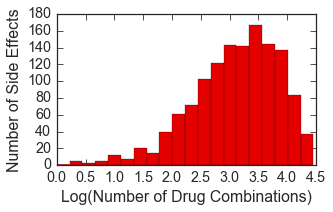

In [8]:
plot_distribution(np.log10(np.asarray(list(zip(*combo_counter.items())[1]))), "",  "Log(Number of Drug Combinations)", "Number of Side Effects", file_name="se_combodist.pdf")

# Side Effect Cooccurrence in Drug Combinations

In [9]:
combos = combo2se.keys()
combo_probability_distribution = np.asarray([len(combo2se[combo])*1.0 for combo in combo2se])
combo_probability_distribution = combo_probability_distribution/np.sum(combo_probability_distribution)

se2combo = defaultdict(set)
for combo in combo2se:
    for se in combo2se[combo]:
        se2combo[se].add(combo)


In [38]:
# Permutation test testing the significancy between the drug combinations a side effect occurs in,
# as compared to other common side effects
def run_permutation_test(se_oi, num_permutations = 2000):
    se_oi_combos = se2combo[se_oi]
    probabilities = []
    for se, count in combo_counter.most_common(51):
        real_combos = se2combo[se]
        real_overlap = len(real_combos.intersection(se_oi_combos))
        permuted_overlaps = []
        for i in range(num_permutations):
            combo_sample = np.random.choice(combos, len(real_combos), replace=False, p=combo_probability_distribution)
            permuted_overlaps += [len(se_oi_combos.intersection(set(combo_sample)))]
        probability = np.sum(np.asarray(permuted_overlaps) >= real_overlap)*1.0/num_permutations
        probabilities += [probability]
        print se, se2name[se], real_overlap, np.mean(permuted_overlaps), probability

In [19]:
# For hypertension
run_permutation_test('C0020538')

C0020649 arterial pressure NOS decreased 10557 11167.9815 1.0
C0002871 anaemia 9457 10625.127 1.0
C0013404 Difficulty breathing 9974 10283.892 1.0
C0027497 nausea 9326 9982.9075 1.0
C0032285 neumonia 9032 9710.207 1.0
C0015672 Fatigue 9169 9649.59 1.0
C0030193 Pain 9804 9517.7725 0.0
C0011991 diarrhea 8625 9504.007 1.0
C0004093 asthenia 9150 9378.761 1.0
C0042963 emesis 8227 9207.9685 1.0
C0085649 edema extremities 9011 8817.7285 0.0
C0015967 body temperature increased 7536 8752.713 1.0
C0008033 pleural pain 8941 8743.758 0.0
C0000737 abdominal pain 8923 8604.419 0.0
C0398353 Hypoventilation 9926 8573.544 0.0
C0008031 chest pain 9986 8459.649 0.0
C0012833 dizziness 8409 8156.227 0.0
C0004604 Back Ache 8879 8054.7355 0.0
C0018681 Head ache 8402 8005.65 0.0
C0020538 High blood pressure 19376 7846.818 0.0
C0009676 confusion 7311 7839.1 1.0
C0011175 dehydration 6877 7739.648 1.0
C0003467 Anxiety 8695 7694.378 0.0
C0035078 kidney failure 7261 7662.1785 1.0
C0043096 loss of weight 7523 7620.

In [20]:
# For nausea
run_permutation_test('C0027497')

C0020649 arterial pressure NOS decreased 13623 13817.0045 1.0
C0002871 anaemia 12668 13139.2885 1.0
C0013404 Difficulty breathing 12823 12717.4965 0.0245
C0027497 nausea 25190 12339.753 0.0
C0032285 neumonia 11075 11998.6785 1.0
C0015672 Fatigue 13570 11923.353 0.0
C0030193 Pain 12699 11758.983 0.0
C0011991 diarrhea 13492 11739.0725 0.0
C0004093 asthenia 13137 11588.0725 0.0
C0042963 emesis 16363 11373.799 0.0
C0085649 edema extremities 11139 10892.2755 0.0
C0015967 body temperature increased 10861 10812.461 0.1805
C0008033 pleural pain 11890 10801.189 0.0
C0000737 abdominal pain 12145 10631.2015 0.0
C0398353 Hypoventilation 11109 10589.1875 0.0
C0008031 chest pain 11003 10447.2235 0.0
C0012833 dizziness 11644 10072.653 0.0
C0004604 Back Ache 11152 9946.1885 0.0
C0018681 Head ache 11346 9885.94 0.0
C0020538 High blood pressure 9326 9688.021 1.0
C0009676 confusion 9862 9682.275 0.0005
C0011175 dehydration 10291 9560.8115 0.0
C0003467 Anxiety 10263 9501.5335 0.0
C0035078 kidney failure 8

# How similar are the drug target profiles of drug combinations?

In [32]:
def jaccard(set1, set2):
    num = len(set(set1).intersection(set(set2)))
    den = len(set(set1).union(set(set2)))
    return num*1.0/den

# Only examining those drugs we have drug target information for
valid = []
for stitch in stitch2se:
    if len(stitch2proteins[stitch]) > 0:
        valid += [stitch]
        
# Jaccard similarity between drug target profiles of drugs in drug combinations
jaccard_combos = {}
for combo in combo2se:
    stitch1, stitch2 = combo2stitch[combo]
    if stitch1 in valid and stitch2 in valid:
        jaccard_combos[combo] = jaccard(stitch2proteins[stitch1], stitch2proteins[stitch2])
        
# Jaccard similarity between drug target profiles of random drugs
jaccard_random = []
for i in range(len(jaccard_sim)):
    stitch1 = np.random.choice(valid, 1, replace=False)[0]
    stitch2 =  np.random.choice(valid, 1, replace=False)[0]
    jaccard_random += [jaccard(stitch2proteins[stitch1], stitch2proteins[stitch2])] 
jaccard_random = np.asarray(jaccard_random)

In [35]:
import pandas as pd

def plot_jaccard_distribution_multiple(ses):
    group_names = {'Random drug pairs': jaccard_random, 'All drug combinations': np.asarray([jaccard_combos[combo] for combo in jaccard_combos])}
    order = ['Random drug pairs', 'All drug combinations'] + [nicknames[se] for se in ses]
    for se in ses:
        se_combos = se2combo[se].intersection(set(jaccard_combos.keys()))
        in_jaccard = np.asarray([jaccard_combos[combo] for combo in se_combos])
        group_name = nicknames[se]
        group_names[group_name] = in_jaccard
    categories = {'No shared drug targets': (-.01, 0), 'Fewer than 50% shared': (0, 0.5), 'More than 50% shared':(0.5, 1)}
    groups, similarities, fractions = [], [], []
    for name in group_names:
        arr = group_names[name]
        for category in categories: 
            min_val, max_val = categories[category]
            value = np.sum((arr > min_val) * (arr <= max_val))*1.0/len(arr)
            groups += [name]
            similarities += [category]
            fractions += [value]
    data = pd.DataFrame({ '' : groups, 'Jaccard Similarity Between Drug Target Profiles': similarities, 'Fraction of Drug Combinations': fractions})
    plt.figure(figsize=(3, 5))
    sns.set_context("paper", font_scale=6)
    sns.set_style('ticks')
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
    g = sns.factorplot(x="Jaccard Similarity Between Drug Target Profiles", y="Fraction of Drug Combinations", hue="", data=data,
                   size=18, kind="bar", palette=['#535456', '#9ea3a8', '#3478e5', '#e74c3c', '#2ecc71', '#cc6c18', '#9b59b6',], x_order=['No shared drug targets','Fewer than 50% shared','More than 50% shared'], hue_order=order)
    plt.tight_layout()
    plt.xlabel('')
    plt.savefig('multiple_dist.pdf')


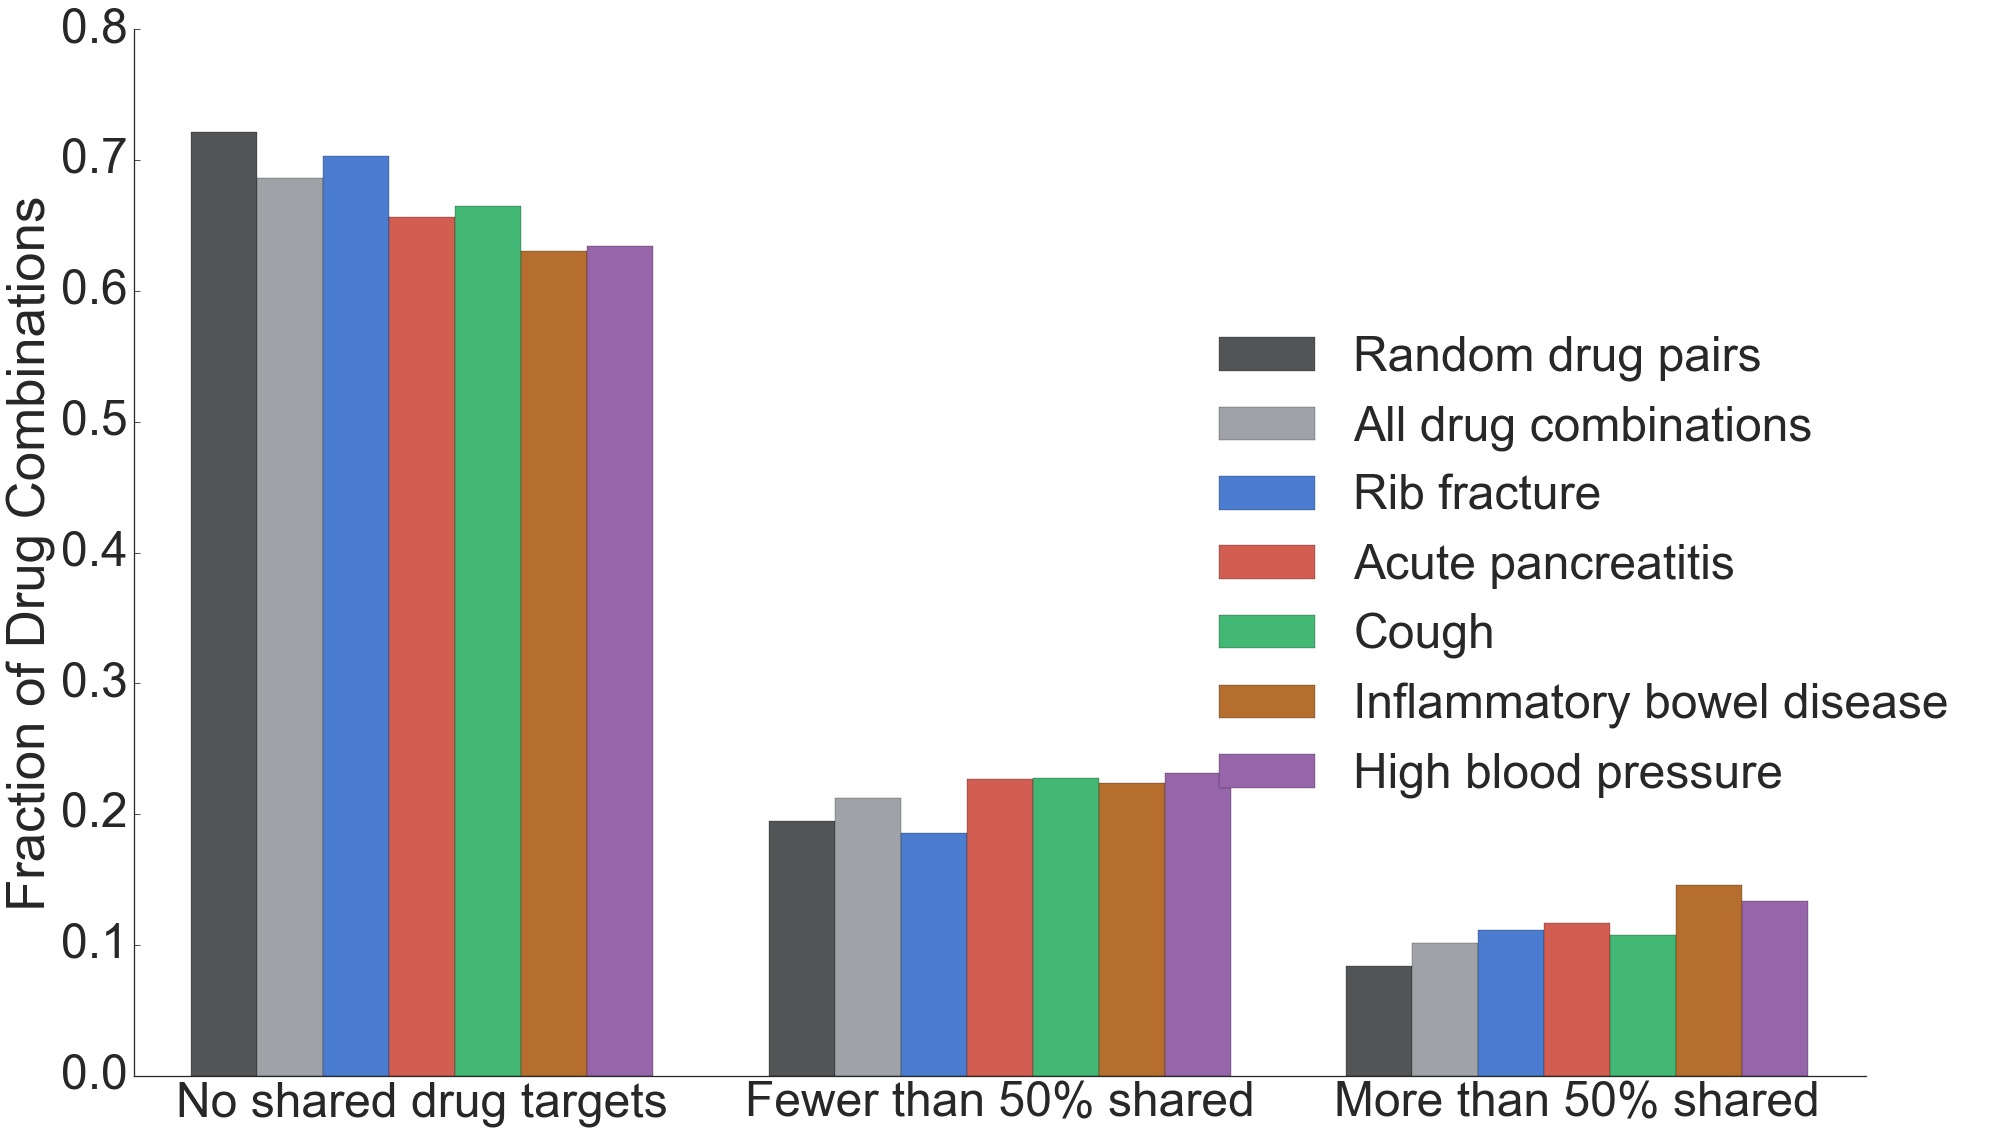

In [36]:
nicknames = {'C0035522': 'Rib fracture', 'C0001339': 'Acute pancreatitis', 'C0010200': 'Cough', 'C0021390': 'Inflammatory bowel disease', 'C0020538': 'High blood pressure'}

plot_jaccard_distribution_multiple(['C0035522', 'C0001339',  'C0010200', 'C0021390', 'C0020538'])